In [1]:
import os
import sys
from pathlib import Path

# Get the notebook's directory
notebook_dir = os.getcwd()

# Add the notebook directory and its parent to Python path
sys.path.append(notebook_dir)
sys.path.append(str(Path(notebook_dir).parent))

# Function to add all subdirectories to Python path
def add_subdirs_to_path():
    for root, dirs, files in os.walk(notebook_dir):
        for dir_name in dirs:
            full_path = os.path.join(root, dir_name)
            if full_path not in sys.path:
                sys.path.append(full_path)

# Add all subdirectories
add_subdirs_to_path()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from data_cleaning.data_consistency_check import check_data_consistency
from feature_engineering import engineer_features
from utils.load_data import load_data

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)

In [4]:
train_df = load_data("../data/train.csv")
train_df = engineer_features(train_df)
test_df = load_data("../data/test.csv")
test_df = engineer_features(test_df)

In [5]:
# there is one suspicious garage in the test set, which has type detached and no other info
# I'll convert it into an NA garage type
qry = (test_df["has_garage"] == 0) & (test_df["GarageType"].astype(str) != "NA")
test_df.loc[qry, "GarageType"] = "NA"

In [6]:
# Checking data consistency after initial cleaning
train_df_check = check_data_consistency(train_df)
test_df_check = check_data_consistency(test_df)

In [7]:
print(sum(~train_df_check["garage_type_consistent"]))
# 0
print(sum(~train_df_check["garage_features_consistent"]))
# 0
print(sum(~train_df_check["garage_area_reasonable"]))
# 55 need to investigate

0
0
55


In [8]:
print(sum(~test_df_check["garage_type_consistent"]))
# 0
print(sum(~test_df_check["garage_features_consistent"]))
# 1
# Id                         2127
# GarageType               Detchd
# GarageYrBlt              1910.0
# GarageFinish                 NA
# GarageCars                  1.0
# GarageArea                360.0
# GarageQual                   NA
# GarageCond                   NA
# need to explore this one
print(sum(~test_df_check["garage_area_reasonable"]))
# 51

0
1
51


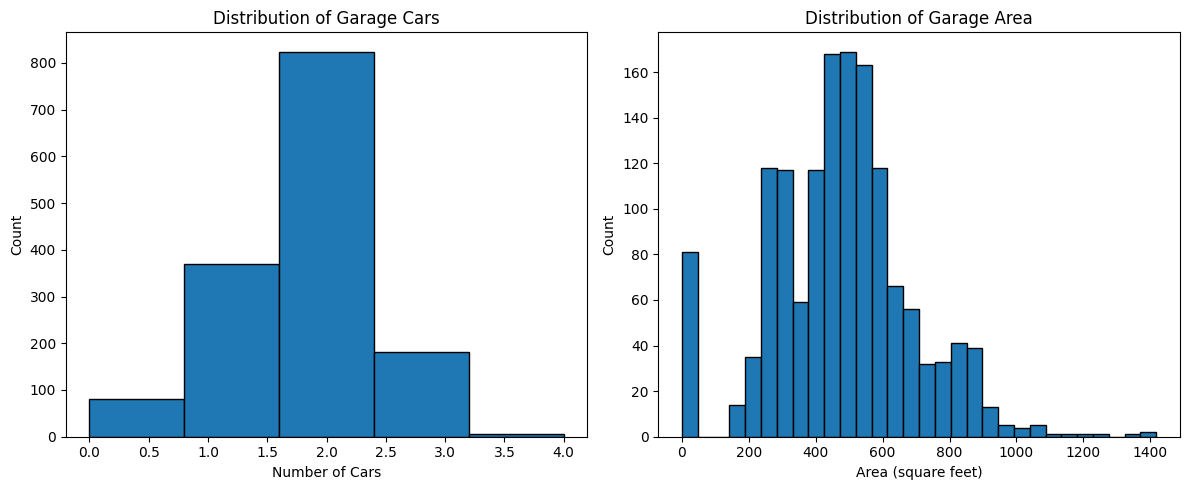

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot GarageCars histogram
ax1.hist(train_df["GarageCars"], bins=5, edgecolor="black")
ax1.set_title("Distribution of Garage Cars")
ax1.set_xlabel("Number of Cars")
ax1.set_ylabel("Count")

# Plot GarageArea histogram
ax2.hist(train_df["GarageArea"], bins=30, edgecolor="black")
ax2.set_title("Distribution of Garage Area")
ax2.set_xlabel("Area (square feet)")
ax2.set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

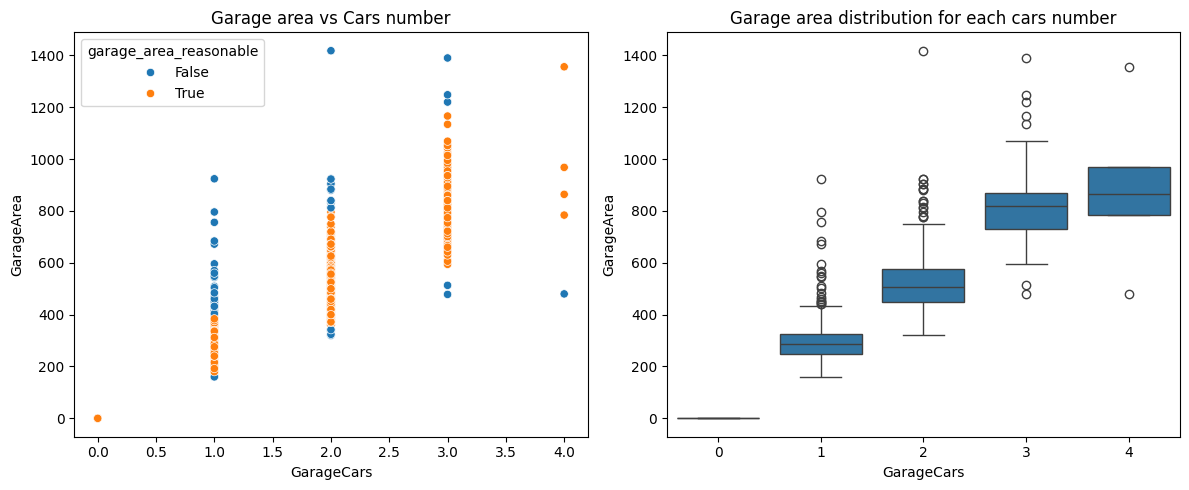

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    train_df_check, x="GarageCars", y="GarageArea", hue="garage_area_reasonable", ax=ax1
)
ax1.set_title("Garage area vs Cars number")

sns.boxplot(train_df_check, x="GarageCars", y="GarageArea", ax=ax2)
ax2.set_title("Garage area distribution for each cars number")
plt.tight_layout()
plt.show()

In [11]:
df = train_df_check[train_df_check["has_garage"] == 1].copy()
df["garage_area_per_car"] = df["GarageArea"] / df["GarageCars"]

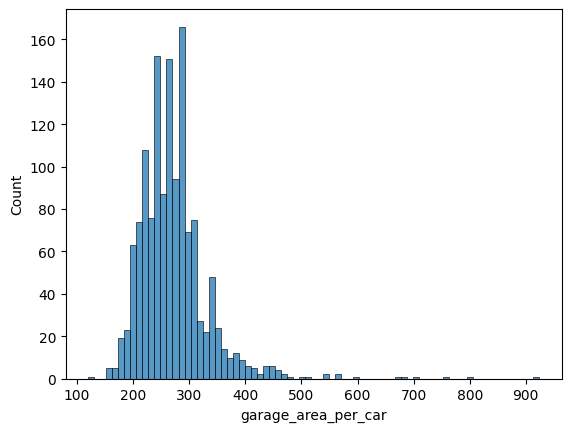

In [12]:
sns.histplot(df, x="garage_area_per_car")
plt.show()

In [13]:
# add feature which determines whether garage area is too small or too large
def create_garage_area_efficiency_feature(df):
    """
    Creates a feature that categorizes garage area efficiency relative to car capacity:
    -1: Garage area is unusually small for the number of cars
     0: Garage area is within normal range for the number of cars
     1: Garage area is unusually large for the number of cars
    """
    # Constants for area ranges (same as in check_garage_area_reasonable)
    area_per_car_low = 180  # Minimum reasonable sq ft per car
    area_per_car_high = 400  # Maximum reasonable sq ft per car

    # Initialize with 0 (normal range)
    df["garage_area_efficiency"] = 0

    # Only evaluate houses with garages
    garage_mask = df["has_garage"] == 1

    # Calculate area per car ratio for houses with garages
    area_per_car = df.loc[garage_mask, "GarageArea"] / df.loc[garage_mask, "GarageCars"]

    # Mark unusually small garages (-1)
    df.loc[
        garage_mask & (area_per_car < area_per_car_low), "garage_area_efficiency"
    ] = -1

    # Mark unusually large garages (1)
    df.loc[
        garage_mask & (area_per_car > area_per_car_high), "garage_area_efficiency"
    ] = 1

    return df

In [14]:
df = create_garage_area_efficiency_feature(train_df_check)
df["garage_area_efficiency"].value_counts()

garage_area_efficiency
 0    1405
 1      44
-1      11
Name: count, dtype: int64

In [15]:
def create_area_per_car_feature(df):
    """
    Creates a feature that calculates garage area per car:
    - For houses with garages: GarageArea / GarageCars
    - For houses without garages: 0
    """
    # Calculate area per car for houses with garages, 0 for houses without
    area_per_car = pd.Series(0.0, index=df.index)  # Initialize with 0

    # Only calculate for houses with garages
    garage_mask = df["has_garage"] == 1
    area_per_car.loc[garage_mask] = (
        df.loc[garage_mask, "GarageArea"] / df.loc[garage_mask, "GarageCars"]
    )

    # Insert the new column after GarageArea
    insert_position = df.columns.get_loc("GarageArea") + 1
    df.insert(insert_position, "area_per_car", area_per_car)

    return df

In [16]:
df = create_area_per_car_feature(df)

In [17]:
df[df["garage_area_efficiency"] == -1].transpose()

,456,482,644,735,857,1022,1048,1149,1340,1343,1376
Id,457,483,645,736,858,1023,1049,1150,1341,1344,1377
MSSubClass,70,70,20,75,60,50,20,70,20,50,30
MSZoning,RM,RM,FV,RM,RL,RM,RL,RM,RL,RL,RL
LotFrontage,34.0,50.0,85.0,60.0,65.0,52.0,100.0,50.0,70.0,57.0,52.0
LotArea,4571,2500,9187,10800,8125,9439,21750,9000,8294,7558,6292
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,Grvl,Pave,NA,NA,NA,NA,NA,NA,NA,NA,NA
LotShape,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Bnk,Bnk
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub


In [18]:
df[df["garage_area_efficiency"] == -1]["GarageFinish"].value_counts(normalize=True)

GarageFinish
Unf    0.818182
Fin    0.181818
NA     0.000000
RFn    0.000000
Name: proportion, dtype: float64

In [19]:
df[df["garage_area_efficiency"] == -1]["GarageFinish"].value_counts(normalize=True)

GarageFinish
Unf    0.818182
Fin    0.181818
NA     0.000000
RFn    0.000000
Name: proportion, dtype: float64

In [20]:
df["GarageFinish"].value_counts(normalize=True)

GarageFinish
Unf    0.414384
RFn    0.289041
Fin    0.241096
NA     0.055479
Name: proportion, dtype: float64

In [21]:
df.loc[
        df["garage_area_efficiency"] == 1,
        [
            "GarageType",
            "GarageYrBlt",
            "GarageFinish",
            "GarageCars",
            "GarageArea",
            "area_per_car",
            "GarageQual",
            "GarageCond",
        ],
    ].sort_values(by=["area_per_car"], ascending=False)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,area_per_car,GarageQual,GarageCond
268,Detchd,1966,Fin,1,924,924.000000,Ex,Ex
946,Attchd,1959,RFn,1,796,796.000000,TA,TA
901,Detchd,1968,Unf,1,756,756.000000,TA,TA
1298,Attchd,2008,Fin,2,1418,709.000000,TA,TA
900,Detchd,1979,Unf,1,684,684.000000,TA,TA
863,Attchd,1959,Unf,1,672,672.000000,TA,TA
395,Attchd,1956,Unf,1,596,596.000000,TA,TA
557,CarPort,1994,Unf,1,570,570.000000,TA,TA
1255,Detchd,1978,Unf,1,560,560.000000,TA,TA
723,Detchd,1958,Unf,1,548,548.000000,TA,TA


In [22]:
df[df["garage_area_efficiency"] == 1]["GarageFinish"].value_counts(normalize=True)

GarageFinish
Unf    0.659091
Fin    0.204545
RFn    0.136364
NA     0.000000
Name: proportion, dtype: float64

In [23]:
df[df["garage_area_efficiency"] == 1]["GarageQual"].value_counts(normalize=True)

GarageQual
TA    0.931818
Ex    0.022727
Gd    0.022727
Po    0.022727
Fa    0.000000
NA    0.000000
Name: proportion, dtype: float64

In [24]:
df[df["garage_area_efficiency"] == 0]["GarageType"].value_counts(normalize=True)

GarageType
Attchd     0.603559
Detchd     0.254804
BuiltIn    0.061210
NA         0.057651
Basment    0.012811
CarPort    0.005694
2Types     0.004270
Name: proportion, dtype: float64

In [25]:
df[df["garage_area_efficiency"] == -1]["GarageType"].value_counts(normalize=True)

GarageType
Detchd     0.636364
Attchd     0.363636
2Types     0.000000
Basment    0.000000
BuiltIn    0.000000
CarPort    0.000000
NA         0.000000
Name: proportion, dtype: float64

In [26]:
df[df["area_per_car"] > 700].transpose()

,268,901,946,1298
Id,269,902,947,1299
MSSubClass,30,20,80,60
MSZoning,RM,RL,RL,RL
LotFrontage,71.0,64.0,70.0,313.0
LotArea,6900,8712,8163,63887
Street,Pave,Pave,Pave,Pave
Alley,NA,NA,NA,NA
LotShape,Reg,IR1,Reg,IR3
LandContour,Lvl,Lvl,Lvl,Bnk
Utilities,AllPub,AllPub,AllPub,AllPub


In [27]:
# Exploring single inconsistent garage in the test set

In [28]:
print(test_df_check[~test_df_check["garage_features_consistent"]].transpose())
# Id                                      2127
# GarageType                            Detchd
# GarageYrBlt                             1910
# GarageFinish                              NA
# GarageCars                               1.0
# GarageArea                             360.0
# GarageQual                                NA
# GarageCond                                NA

                                         666
Id                                      2127
MSSubClass                                60
MSZoning                                  RM
LotFrontage                             57.0
LotArea                                 8094
Street                                  Pave
Alley                                   Grvl
LotShape                                 Reg
LandContour                              Lvl
Utilities                             AllPub
LotConfig                             Inside
LandSlope                                Gtl
Neighborhood                         OldTown
Condition1                              Norm
Condition2                              Norm
BldgType                              2fmCon
HouseStyle                            2.5Unf
OverallQual                                6
OverallCond                                8
YearBuilt                               1910
YearRemodAdd                            1983
RoofStyle 

In [29]:
# Dealing with GarageFinish
print(pd.crosstab(train_df_check["GarageType"], train_df_check["GarageFinish"]))
# GarageFinish  NA  Unf  RFn  Fin
# GarageType                     
# 2Types         0    3    2    1
# Attchd         0  225  371  274
# Basment        0    9    6    4
# BuiltIn        0    5   24   59
# CarPort        0    9    0    0
# Detchd         0  354   19   14
# NA            81    0    0    0

# It makes sense to impute GarageFinish with Unf

GarageFinish  NA  Unf  RFn  Fin
GarageType                     
2Types         0    3    2    1
Attchd         0  225  371  274
Basment        0    9    6    4
BuiltIn        0    5   24   59
CarPort        0    9    0    0
Detchd         0  354   19   14
NA            81    0    0    0


In [30]:
# Dealing with GarageQual
print(pd.crosstab(train_df_check["GarageType"], train_df_check["GarageQual"]))
# GarageQual  Ex  Gd   TA  Fa  Po  NA
# GarageType                         
# 2Types       0   0    5   1   0   0
# Attchd       0   9  855   6   0   0
# Basment      0   0   17   2   0   0
# BuiltIn      0   1   87   0   0   0
# CarPort      0   0    7   2   0   0
# Detchd       3   4  340  37   3   0
# NA           0   0    0   0   0  81

GarageQual  Ex  Gd   TA  Fa  Po  NA
GarageType                         
2Types       0   0    5   1   0   0
Attchd       0   9  855   6   0   0
Basment      0   0   17   2   0   0
BuiltIn      0   1   87   0   0   0
CarPort      0   0    7   2   0   0
Detchd       3   4  340  37   3   0
NA           0   0    0   0   0  81


In [31]:
print(pd.crosstab(train_df_check["GarageQual"], train_df_check["OverallQual"]))
#                                   ↓
# OverallQual  1  2   3   4    5    6    7    8   9  10
# GarageQual                                           
# Ex           0  0   0   0    1    1    0    0   0   1
# Gd           0  0   0   0    3    4    3    3   0   1
# TA           0  2  12  80  340  344  310  164  43  16
# Fa           0  0   2  10   19   12    5    0   0   0
# Po           0  0   0   0    2    1    0    0   0   0
# NA           2  1   6  26   32   12    1    1   0   0

OverallQual  1  2   3   4    5    6    7    8   9  10
GarageQual                                           
Ex           0  0   0   0    1    1    0    0   0   1
Gd           0  0   0   0    3    4    3    3   0   1
TA           0  2  12  80  340  344  310  164  43  16
Fa           0  0   2  10   19   12    5    0   0   0
Po           0  0   0   0    2    1    0    0   0   0
NA           2  1   6  26   32   12    1    1   0   0


In [32]:
# Based on the tables above GarageQual is likely to be TA

In [33]:
# Dealing with GarageCond
print(pd.crosstab(train_df_check["GarageType"], train_df_check["GarageCond"]))
# GarageCond  Ex  Gd   TA  Fa  Po  NA
# GarageType                         
# 2Types       0   0    5   1   0   0
# Attchd       0   7  861   2   0   0
# Basment      0   0   19   0   0   0
# BuiltIn      0   0   88   0   0   0
# CarPort      0   0    8   1   0   0
# Detchd       2   2  345  31   7   0
# NA           0   0    0   0   0  81

GarageCond  Ex  Gd   TA  Fa  Po  NA
GarageType                         
2Types       0   0    5   1   0   0
Attchd       0   7  861   2   0   0
Basment      0   0   19   0   0   0
BuiltIn      0   0   88   0   0   0
CarPort      0   0    8   1   0   0
Detchd       2   2  345  31   7   0
NA           0   0    0   0   0  81


In [34]:
print(pd.crosstab(train_df_check["GarageCond"], train_df_check["OverallCond"]))
# OverallCond  1  2   3   4    5    6    7   8   9
# GarageCond                                      
# Ex           0  0   0   0    0    2    0   0   0
# Gd           0  0   0   0    3    0    6   0   0
# TA           0  1  16  48  778  227  175  61  20
# Fa           0  1   3   3   10    6    6   6   0
# Po           0  1   0   0    3    2    0   1   0
# NA           1  2   6   6   27   15   18   4   2

OverallCond  1  2   3   4    5    6    7   8   9
GarageCond                                      
Ex           0  0   0   0    0    2    0   0   0
Gd           0  0   0   0    3    0    6   0   0
TA           0  1  16  48  778  227  175  61  20
Fa           0  1   3   3   10    6    6   6   0
Po           0  1   0   0    3    2    0   1   0
NA           1  2   6   6   27   15   18   4   2


In [35]:
# Again, TA must be the best choice for the GarageCond